In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

In [2]:
def findFiles(path): return glob.glob(path)

In [3]:
print(findFiles('data/names/*.txt'))

['data/names/German.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt', 'data/names/Italian.txt', 'data/names/Polish.txt', 'data/names/Korean.txt', 'data/names/English.txt', 'data/names/Greek.txt', 'data/names/Dutch.txt', 'data/names/Arabic.txt', 'data/names/Czech.txt', 'data/names/French.txt', 'data/names/Chinese.txt', 'data/names/Portuguese.txt', 'data/names/Japanese.txt', 'data/names/Irish.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt']


In [4]:
import unicodedata
import string

In [5]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [6]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c) != 'Mn' and c in all_letters
    )

In [7]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [8]:
category_lines = {}
all_categories = []

In [9]:
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [10]:
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

In [11]:
n_categories = len(all_categories)

In [12]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [13]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size()) # Char_in_name x 1 x Char_in_alphabet(here 57)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [14]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [15]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output.size())

torch.Size([1, 18])


In [16]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Arabic', 9)


In [17]:
import random
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Arabic / line = Handal
category = Dutch / line = Ankeren
category = Czech / line = Krawiec
category = Czech / line = Borowski
category = Polish / line = Majewski
category = Polish / line = Budny
category = French / line = Sauvageot
category = Arabic / line = Sleiman
category = Scottish / line = Black
category = English / line = Collins


In [18]:
criterion = nn.NLLLoss()

In [19]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [20]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 3s) 2.0570 Rovnev / Russian ✓
10000 10% (0m 7s) 2.3534 Suero / Portuguese ✗ (Spanish)
15000 15% (0m 11s) 1.8942 Newell / English ✓
20000 20% (0m 15s) 2.8647 Shearer / German ✗ (English)
25000 25% (0m 19s) 1.1428 Duncan / Irish ✓
30000 30% (0m 23s) 1.1446 Scordato / Italian ✓
35000 35% (0m 27s) 1.5385 Malecha / Portuguese ✗ (Czech)
40000 40% (0m 31s) 2.2116 Alker / Dutch ✗ (English)
45000 45% (0m 35s) 1.2911 Letsos / Greek ✓
50000 50% (0m 39s) 1.7236 Dubicki / Japanese ✗ (Polish)
55000 55% (0m 43s) 0.0896 Wojewodka / Polish ✓
60000 60% (0m 47s) 0.3851 Antoun / Arabic ✓
65000 65% (0m 51s) 1.8839 Vederman / Irish ✗ (Russian)
70000 70% (0m 55s) 4.1327 Deeb / Vietnamese ✗ (Arabic)
75000 75% (0m 58s) 2.0060 Sansone / French ✗ (Italian)
80000 80% (1m 3s) 2.4804 Johnston / English ✗ (Scottish)
85000 85% (1m 6s) 0.7179 Fabre / French ✓
90000 90% (1m 10s) 0.1377 Albrici / Italian ✓
95000 95% (1m 14s) 2.1185 Mateu / French ✗ (Spanish)
100000 100% (1m 18s) 1.5785 Chermak / Polish ✗ (Cz

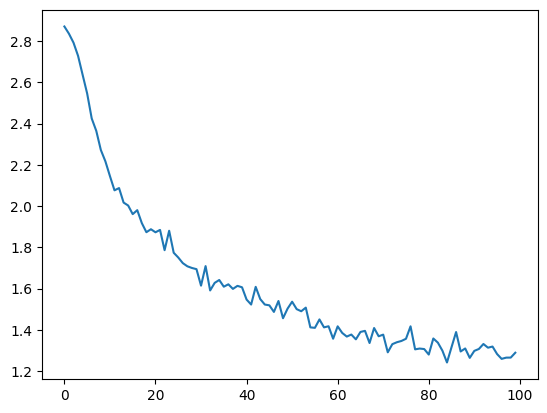

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [22]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

In [23]:
categoryFromOutput(evaluate(lineToTensor('Dovesky')))

('Russian', 16)

/tmp/ipykernel_1757643/251369202.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_1757643/251369202.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


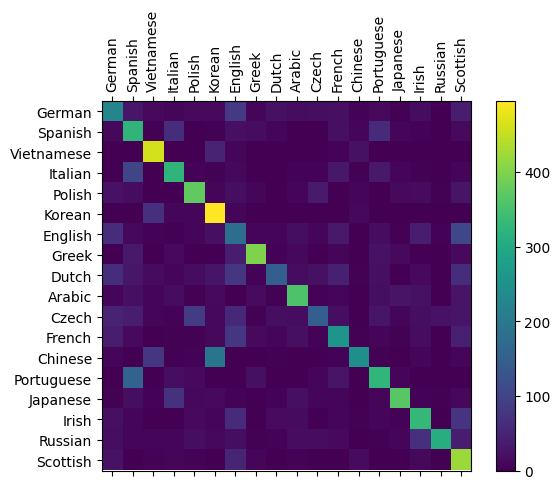

In [24]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# # Normalize by dividing every row by its sum
# for i in range(n_categories):
#     confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()
